In [3]:
import sys
sys.path.append('/ossfs/workspace/jd_paper/mydata/')
sys.path.append('/ossfs/workspace/jd_paper/HGT-semi/')
import scipy.io
import urllib.request
import dgl
import math
import numpy as np
import pandas as pd
from model import *
import torch
from data_loader import data_loader
from utils.data import load_data
from utils.pytorchtools import EarlyStopping
from utils.tools import evaluate_results_nc
import argparse
import time

from collections import defaultdict

def node_aug_heterograph(features_list, dataset, G, model, k):
    sim = {}
    sim1 = {}
    distance0,distance1 = {},{}
        
    logits1, logits2, embeddings1, embeddings2 ,adapt_fes= model(G, '0')

    for i, meta_path in dataset.links['meta'].items():
        nid1 = dataset.links['data'][i].tocoo().row - dataset.nodes['shift'][meta_path[0]]
        nid2 = dataset.links['data'][i].tocoo().col - dataset.nodes['shift'][meta_path[1]]
        etype = str(meta_path[0]) + '_' + str(meta_path[1])
        distance0[int(meta_path[0])] = dataset.nodes['shift'][meta_path[0]]
        distance1[int(meta_path[1])] = dataset.nodes['shift'][meta_path[1]]
        
        if str(meta_path[0]) + '_' + str(meta_path[1]) == '0_0':
            [(0, 3025), (1, 5959), (2, 56)]
            sim1[int(meta_path[1])] = torch.zeros([3025,3025])
        elif str(meta_path[0]) + '_' + str(meta_path[1]) == '0_1':
            sim1[int(meta_path[1])] = torch.zeros([3025,5959])
        elif str(meta_path[0]) + '_' + str(meta_path[1]) == '0_2':
            sim1[int(meta_path[1])] = torch.zeros([3025,56])
        elif str(meta_path[0]) + '_' + str(meta_path[1]) == '1_0':
            sim1[int(meta_path[1])] = torch.zeros([5959,3025])
        elif str(meta_path[0]) + '_' + str(meta_path[1]) == '2_0':
            sim1[int(meta_path[1])] = torch.zeros([56,3025])
        sim[int(meta_path[0])] = sim1
#         print('max(nid1)>>>>>>>>>>>',max(nid1)+1)
#         print('max(nid2)>>>>>>>>>>>',max(nid2)+1)

        target_fe = adapt_fes[str(meta_path[0])][nid1]
        neigh_fe = adapt_fes[str(meta_path[1])][nid2]
        sim_fe = torch.sum(target_fe.mul(neigh_fe), dim=1)  # dim=len(nid1)*1,对应位置元素点乘后，每一行求和。相当于对应行的向量点积
        sim_fe = sim_fe.reshape(len(sim_fe),-1)

        att_weights = abs(G.edges[etype].data["a"].detach().cpu().numpy()).mean(axis=1) # dim=len(nid1)*1
        att_weights = torch.tensor(att_weights).reshape(len(att_weights),-1).cuda()
        final_weights = sim_fe*att_weights
        for ni in range(len(nid1)):
            sim[int(meta_path[0])][int(meta_path[1])][nid1[ni]][nid2[ni]] = final_weights[ni]

    sim2 = sim.copy()

    for idx in range(3025):
        target_fe = adapt_fes['0'][idx].clone()
#         print('nid1[ni]>>>>>>>>>>>',sim2[0][0].size(),sim2[0][1].size(),sim2[0][2].size())
        
        sim_tensor = torch.cat((sim2[0][0],sim2[0][1],sim2[0][2]),axis=1)
#         print('sim_tensor>>>>>>>',torch.argmax(sim_tensor[0]))
        for kk in range(k):
            max_id = torch.argmax(sim_tensor[idx])
#             print('max_id>>>>>>>',max_id,distance1[0],distance1[1],distance1[2])
            if max_id>=distance1[0] and max_id<distance1[1]:
                max_id = max_id
                ntype = 0
            elif max_id>=distance1[1] and max_id<distance1[2]:
                max_id = max_id-distance1[1]
                ntype = 1
            elif max_id>=distance1[2]:
                max_id = max_id-distance1[2]
                ntype = 2
            if kk==0:
                neigh_fes = adapt_fes[str(ntype)][max_id].reshape(1,len(adapt_fes[str(ntype)][max_id])).clone()
            else:
                neigh_fes = torch.cat((neigh_fes,adapt_fes[str(ntype)][max_id].reshape(1,len(adapt_fes[str(ntype)][max_id]))),axis=0)
            
            sim2[0][ntype][idx][max_id] = 0
            adapt_fes[str(ntype)][max_id] = target_fe

        neigh_fes = torch.tensor(neigh_fes, dtype=torch.float).clone()
        neigh_fes = neigh_fes.mean(axis=0)    
        adapt_fes['0'][idx] = neigh_fes
    return G

def sp_to_spt(mat):
    coo = mat.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape))


def mat2tensor(mat):
    if type(mat) is np.ndarray:
        return torch.from_numpy(mat).type(torch.FloatTensor)
    return sp_to_spt(mat)

def build_heterograph(args):
    if args.device >= 0:
        device = torch.device("cuda:"+str(args.device))
    else:
        device = torch.device('cpu')
    
    print('loading data >>>>>>>>>>>>>>>>>>>>>')
    dataset = data_loader('/ossfs/workspace/jd_paper/mydata/'+args.dataset)
    edge_dict = {}
    print('node_total',dataset.nodes['total'])

    for i, meta_path in dataset.links['meta'].items():
#         print('**************************')
        edge_dict[(str(meta_path[0]), str(meta_path[0]) + '_' + str(meta_path[1]), str(meta_path[1]))] = (torch.tensor(dataset.links['data'][i].tocoo().row - dataset.nodes['shift'][meta_path[0]]), torch.tensor(dataset.links['data'][i].tocoo().col - dataset.nodes['shift'][meta_path[1]]))
        
        
    node_count = {}
    print(dataset.nodes['count'].items())
    for i, count in dataset.nodes['count'].items():
        print(i, node_count)
        node_count[str(i)] = count

    print('building dgl.heterograph >>>>>>>>>>>>>>>>>>>>>')
    print('edge_dict>>>>>>>>',edge_dict)
    G = dgl.heterograph(edge_dict, num_nodes_dict = node_count, device=device)
    """
    for ntype in G.ntypes:
        G.nodes[ntype].data['inp'] = dataset.nodes['attr'][ntype]
        # print(G.nodes['attr'][ntype].shape)
    """

    G.node_dict = {}
    G.edge_dict = {}
    for ntype in G.ntypes:
        G.node_dict[ntype] = len(G.node_dict)
    for etype in G.etypes:
        G.edge_dict[etype] = len(G.edge_dict)
        G.edges[etype].data['id'] = torch.ones(G.number_of_edges(etype), dtype=torch.long).to(device) * G.edge_dict[etype] 
#     print('G*****',G)
    return G,dataset

def run_model_DBLP(args, G, dataset, rep):
    if args.device >= 0:
        device = torch.device("cuda:"+str(args.device))
    else:
        device = torch.device('cpu')
    
    feats_type = args.feats_type
    features_list, adjM, labels, train_val_test_idx, dl = load_data(args.dataset)
    print('features_list>>>>>> ',len(features_list),len(features_list[0][0]),len(features_list[1][0])) #,len(features_list[2][0]),len(features_list[3][0])
    features_list = [mat2tensor(features).to(device) for features in features_list]

    if feats_type == 0:
        in_dims = [features.shape[1] for features in features_list]
    elif feats_type == 1 or feats_type == 5:
        save = 0 if feats_type == 1 else 2
        in_dims = []#[features_list[0].shape[1]] + [10] * (len(features_list) - 1)
        for i in range(0, len(features_list)):
            if i == save:
                in_dims.append(features_list[i].shape[1])
            else:
                in_dims.append(10)
                features_list[i] = torch.zeros((features_list[i].shape[0], 10)).to(device)
    elif feats_type == 2 or feats_type == 4:
        save = feats_type - 2
        in_dims = [features.shape[0] for features in features_list]
        for i in range(0, len(features_list)):
            if i == save:
                in_dims[i] = features_list[i].shape[1]
                continue
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
    elif feats_type == 3:
        in_dims = [features.shape[0] for features in features_list]
        for i in range(len(features_list)):
            dim = features_list[i].shape[0]
            indices = np.vstack((np.arange(dim), np.arange(dim)))
            indices = torch.LongTensor(indices)
            values = torch.FloatTensor(np.ones(dim))
            features_list[i] = torch.sparse.FloatTensor(indices, values, torch.Size([dim, dim])).to(device)
#     print('features_list>>>>',features_list)

    ## 添加图特征
    for ntype in G.ntypes:
        G.nodes[ntype].data['inp'] = features_list[int(ntype)]#.to(device)
    labels = torch.LongTensor(labels).to(device)
    train_idx = train_val_test_idx['train_idx']
    train_idx = np.sort(train_idx)
    val_idx = train_val_test_idx['val_idx']
    val_idx = np.sort(val_idx)
    test_idx = train_val_test_idx['test_idx']
    test_idx = np.sort(test_idx)
    unlabel_idx = train_val_test_idx['unlabel_idx']
    unlabel_idx = np.sort(unlabel_idx)
    
    
    ## kk
    is_label = torch.ones(len(G.nodes['0'].data['inp'])).view(-1,1)
    is_label[unlabel_idx]=0
    for ntype in G.ntypes:
        if ntype == '0':
            G.nodes[ntype].data['is_label'] = is_label.to(device)
        else:
            G.nodes[ntype].data['is_label'] = torch.zeros(len(G.nodes[ntype].data['inp'])).view(-1,1).to(device)
    ## kk

    print(len(train_idx), len(test_idx), len(val_idx), len(unlabel_idx))
    model = HGT(G, n_inps=in_dims, n_hid=args.hidden_dim, n_out=labels.max().item()+1, n_layers=args.num_layers, n_heads=args.num_heads, unlabel_idx=unlabel_idx, use_norm = args.use_norm).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=args.weight_decay)#, lr=args.lr, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=args.schedule_step, max_lr = 1e-3, pct_start=0.05)

    early_stopping = EarlyStopping(patience=args.patience, verbose=True, save_path='/ossfs/workspace/jd_paper/result/checkpoint_{}_{}l_{}th.pt'.format(args.dataset, args.num_layers, rep))
    train_step = 0
    for epoch in range(args.epoch):
        with torch.autograd.set_detect_anomaly(True):
            t_start = time.time()
            model.train()
            G2 = node_aug_heterograph(features_list, dl, G, model, 2)  
            logits1, logits2, embeddings1, embeddings2 = model(G2, '0')
            print('cross_entropy>>>>>>>> ',F.cross_entropy(logits1[train_idx], labels[train_idx].to(device)))
            print('mse_loss>>>>>>>> ',F.mse_loss(logits1[unlabel_idx],logits2[unlabel_idx]))
#             print('logits1[unlabel_idx]',logits1[unlabel_idx])
#             print('logits2[unlabel_idx]',logits2[unlabel_idx])
            train_loss = (1-args.rate)*F.cross_entropy(logits1[train_idx], labels[train_idx].to(device)) + args.rate*(F.mse_loss(logits1[unlabel_idx],logits2[unlabel_idx]))
#             train_loss = F.cross_entropy(logits1[train_idx], labels[train_idx].to(device)) - F.mse_loss(logits11,logits2)
            pred = logits1.argmax(1)
            train_acc = (pred[train_idx] == labels[train_idx]).float().mean()
        

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            train_step += 1
            scheduler.step(train_step)
            t_end = time.time()
        print('Epoch {:05d} | Train_Loss: {:.4f} | Train_acc: {:.4f} |Time: {:.4f}'.format(epoch, train_loss.item(), train_acc.item(), t_end-t_start))
        t_start = time.time()
        model.eval()
        with torch.no_grad():
            logits1, logits2, val_embeddings1, val_embeddings2 = model(G, '0')
            
            val_loss = F.cross_entropy(logits1[val_idx], labels[val_idx])
            pred = logits1.cpu().numpy().argmax(axis=1)
            pred2 = logits2.cpu().numpy().argmax(axis=1)
        val_acc   = (pred[val_idx] == labels[val_idx].cpu().numpy()).mean()
        test_acc  = (pred[test_idx] == labels[test_idx].cpu().numpy()).mean()
        test_pred_ = pred[test_idx]
        
        val_acc2   = (pred2[val_idx] == labels[val_idx].cpu().numpy()).mean()
        print('val_acc2>>>>>>',val_acc2)
        
        t_end = time.time()
        print('Epoch {:05d} | Val_Loss {:.4f} | Val_acc {:.4f} | Test_acc {:.4f} | Time(s) {:.4f}'.format(
            epoch, val_loss.item(), val_acc.item(), test_acc.item(), t_end - t_start))
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print('Early stopping!')
            return model,test_idx,dataset,dl 
    return model,test_idx,dataset,dl
  
def inference(args, model, test_idx, dataset, G, rep, dl):
    model.load_state_dict(torch.load('/ossfs/workspace/jd_paper/result/checkpoint_{}_{}l_{}th.pt'.format(args.dataset, args.num_layers, rep)))
    model.eval()
#     test_logits = []
    with torch.no_grad():
        logits, _, test_embeddings, _, = model(G, '0')
        test_logits = logits[test_idx]
        
        if args.dataset == 'IMDB1':
            pred = test_logits.cpu().numpy()
        else:
            pred = test_logits.cpu().numpy().argmax(axis=1)
        
        onehot = np.eye(dataset.labels_train['num_classes'], dtype=np.int32)
        pred = onehot[pred]
                
        eval_res = dataset.evaluate(pred)
        print(eval_res['micro-f1'], eval_res['macro-f1'])
        
        svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = evaluate_results_nc(
                test_embeddings[test_idx].cpu().numpy(), dataset.labels_test['data'][dataset.labels_test['mask']].argmax(axis=1), num_classes=dataset.labels_test['num_classes'])

        return eval_res,svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch


In [5]:

# if __name__ == '__main__':
ap = argparse.ArgumentParser(description='MRGNN testing for the DBLP dataset')
ap.add_argument('--feats-type', type=int, default=0,
                help='Type of the node features used. ' +
                        '0 - loaded features; ' +
                        '1 - only target node features (zero vec for others); ' +
                        '2 - only target node features (id vec for others); ' +
                        '3 - all id vec. Default is 2;' +
                    '4 - only term features (id vec for others);' + 
                    '5 - only term features (zero vec for others).')
ap.add_argument('--hidden_dim', type=int, default=64, help='Dimension of the node hidden state. Default is 64.')
ap.add_argument('--num_heads', type=int, default=8, help='Number of the attention heads. Default is 8.')
ap.add_argument('--epoch', type=int, default=500, help='Number of epochs.')
ap.add_argument('--patience', type=int, default=30, help='Patience.')
ap.add_argument('--repeat', type=int, default=5, help='Repeat the training and testing for N times. Default is 1.')
ap.add_argument('--num_layers', type=int, default=5) #5
ap.add_argument('--lr', type=float, default=1e-2) #5e-3
ap.add_argument('--dropout', type=float, default=0)
ap.add_argument('--weight-decay', type=float, default=1e-3) #1e-4
ap.add_argument('--slope', type=float, default=0.05)
ap.add_argument('--dataset', type=str, default='DBLP')  # ACM
ap.add_argument('--edge-feats', type=int, default=64)
ap.add_argument('--device', type=int, default=0)
ap.add_argument('--schedule_step', type=int, default=500)
ap.add_argument('--use_norm', type=bool, default=True)
ap.add_argument('--rate', type=float, default=0.2)

args = ap.parse_args(args=[])
g, dataset = build_heterograph(args)

# 4种类型的节点统一编号
# labels_test1 = pd.read_csv("/ossfs/workspace/jd_paper/data/"+args.dataset+"/label.dat.test", sep = "\t", header=None,
#                  names=["node_id","node_name","node_type","label"])

micro,macro = [],[]
svm_macro_f1_lists,svm_micro_f1_lists,nmi_mean_list,nmi_std_list,ari_mean_list,ari_std_list = [],[],[],[],[],[]
for r in range(args.repeat):
    print('running the '+str(r)+' times >>>>>>>>>>>>')
#     model,test_idx,dataset,dl = run_model_DBLP(args, g, dataset, r, labels_test1)
    model,test_idx,dataset,dl = run_model_DBLP(args, g, dataset, r)
    eval_res,svm_macro_f1_list, svm_micro_f1_list, nmi_mean, nmi_std, ari_mean, ari_std = inference(args, model, test_idx, dataset, g, r, dl)
    macro.append(eval_res['macro-f1'])
    micro.append(eval_res['micro-f1'])
    svm_macro_f1_lists.append(svm_macro_f1_list)
    svm_micro_f1_lists.append(svm_micro_f1_list)
    nmi_mean_list.append(nmi_mean)
    nmi_std_list.append(nmi_std)
    ari_mean_list.append(ari_mean)
    ari_std_list.append(ari_std)

    
m_macro = np.mean(macro)
std_macro = np.std(macro)
m_micro = np.mean(micro)
std_micro = np.std(micro)
sqrt_n = np.sqrt(len(micro))
print('------------------------------ final result ----------------------------------------')
print('final result macro_f1 >>>>>>>>>> ',m_macro,'+-',1.96*std_macro/sqrt_n)
print('final result micro_f1 >>>>>>>>>> ',m_micro,'+-',1.96*std_micro/sqrt_n)

# print out a summary of the evaluations
svm_macro_f1_lists = np.transpose(np.array(svm_macro_f1_lists), (1, 0, 2))
svm_micro_f1_lists = np.transpose(np.array(svm_micro_f1_lists), (1, 0, 2))
nmi_mean_list = np.array(nmi_mean_list)
nmi_std_list = np.array(nmi_std_list)
ari_mean_list = np.array(ari_mean_list)
ari_std_list = np.array(ari_std_list)
print('----------------------------------------------------------------')
print('SVM tests summary')
print('Macro-F1: ' + ', '.join(['{:.6f}~{:.6f} ({:.1f})'.format(
    macro_f1[:, 0].mean(), macro_f1[:, 1].mean(), train_size) for macro_f1, train_size in
    zip(svm_macro_f1_lists, [0.8, 0.6, 0.4, 0.2])]))
print('Micro-F1: ' + ', '.join(['{:.6f}~{:.6f} ({:.1f})'.format(
    micro_f1[:, 0].mean(), micro_f1[:, 1].mean(), train_size) for micro_f1, train_size in
    zip(svm_micro_f1_lists, [0.8, 0.6, 0.4, 0.2])]))
print('K-means tests summary')
print('NMI: {:.6f}~{:.6f}'.format(nmi_mean_list.mean(), nmi_std_list.mean()))
print('ARI: {:.6f}~{:.6f}'.format(ari_mean_list.mean(), ari_std_list.mean()))


loading data >>>>>>>>>>>>>>>>>>>>>
node_total 26128
dict_items([(0, 4057), (1, 14328), (2, 7723), (3, 20)])
0 {}
1 {'0': 4057}
2 {'0': 4057, '1': 14328}
3 {'0': 4057, '1': 14328, '2': 7723}
building dgl.heterograph >>>>>>>>>>>>>>>>>>>>>
edge_dict>>>>>>>> {('1', '1_0', '0'): (tensor([    0,     1,     2,  ..., 14327, 14327, 14327], dtype=torch.int32), tensor([ 262,  263,  263,  ...,  324, 1068, 3647], dtype=torch.int32)), ('1', '1_2', '2'): (tensor([    0,     0,     0,  ..., 14327, 14327, 14327], dtype=torch.int32), tensor([   4,    5,    6,  ...,  586,  730, 1311], dtype=torch.int32)), ('1', '1_3', '3'): (tensor([    0,     1,     2,  ..., 14325, 14326, 14327], dtype=torch.int32), tensor([ 0,  0,  0,  ..., 19, 19, 19], dtype=torch.int32)), ('0', '0_1', '1'): (tensor([   0,    0,    1,  ..., 4054, 4055, 4056], dtype=torch.int32), tensor([ 2364,  6457,  2365,  ..., 13891, 13891, 13892], dtype=torch.int32)), ('2', '2_1', '1'): (tensor([   0,    0,    0,  ..., 7720, 7721, 7722], dtype=tor

/ossfs/workspace/jd_paper/HGT-semi/model.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  unlabel_idx = (is_label == 0).nonzero()[:,0]


IndexError: index 3120 is out of bounds for dimension 0 with size 3025

In [ ]:
1

In [14]:

import pandas as pd
from data_loader import gen_file_for_evaluate
data = 'DBLP'

for i in range(5):
    df = pd.read_csv('../result/'+data+'_'+str(i)+'.txt', sep='\t', names=["node_id","node_name","node_type","label"])
    df[['label']].to_csv('../result1/'+data+'_'+str(i)+'.txt', sep='\t',index=False, header = False)

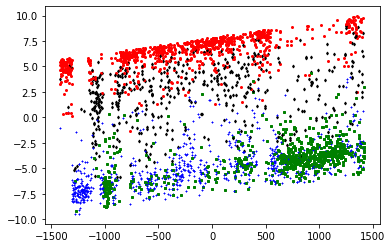

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('../SemiData/kmeans_res_DBLP_semi.csv')

emb = data.drop(['y_pred'],axis=1)
y_pred = data['y_pred'].values

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(emb)
X_new = pca.transform(emb)

mark=['or','+b','sg','dk','^r','py']
j=0
for i in y_pred:
    plt.plot(X_new[j:j+1,0],X_new[j:j+1,1],mark[i],markersize=2)
    j += 1
plt.show()

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('../SemiData/kmeans_res.csv')

emb = data.drop(['y_pred'],axis=1)
y_pred = data['y_pred'].values

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# pca = PCA(n_components=2)
# pca.fit(emb)
# X_new = pca.transform(emb)

tsne = TSNE(n_components=2)
X_new = tsne.fit_transform(emb)

mark=['or','+b','sg','dk','py']
j=0
for i in y_pred:
    plt.plot(X_new[j:j+1,0],X_new[j:j+1,1],mark[i],markersize=5)
    j += 1
plt.show()

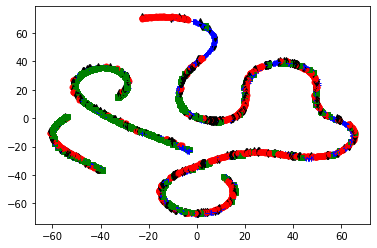

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('../SemiData/kmeans_res_DBLP_semi.csv')

emb = data.drop(['y_pred'],axis=1)
y_pred = data['y_pred'].values

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# pca = PCA(n_components=2)
# pca.fit(emb)
# X_new = pca.transform(emb)

tsne = TSNE(n_components=2)
X_new = tsne.fit_transform(emb)

mark=['or','+b','sg','dk','py']
j=0
for i in y_pred:
    plt.plot(X_new[j:j+1,0],X_new[j:j+1,1],mark[i],markersize=5)
    j += 1
plt.show()

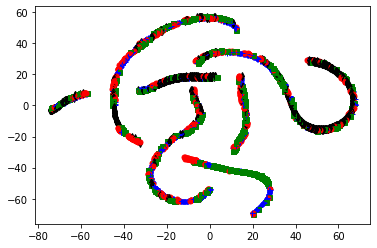

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('../SemiData/kmeans_res_DBLP_consis.csv')

emb = data.drop(['y_pred'],axis=1)
y_pred = data['y_pred'].values

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# pca = PCA(n_components=2)
# pca.fit(emb)
# X_new = pca.transform(emb)

tsne = TSNE(n_components=2)
X_new = tsne.fit_transform(emb)

mark=['or','+b','sg','dk','py']
j=0
for i in y_pred:
    plt.plot(X_new[j:j+1,0],X_new[j:j+1,1],mark[i],markersize=5)
    j += 1
plt.show()